In [1]:
%%javascript
/**********************************************************************************************
Known Mathjax Issue with Chrome - a rounding issue adds a border to the right of mathjax markup
https://github.com/mathjax/MathJax/issues/1300
A quick hack to fix this based on stackoverflow discussions: 
http://stackoverflow.com/questions/34277967/chrome-rendering-mathjax-equations-with-a-trailing-vertical-line
**********************************************************************************************/

$('.math>span').css("border-left-color","transparent")

<IPython.core.display.Javascript object>

In [2]:
%reload_ext autoreload
%autoreload 2

# MIDS - w261 Machine Learning At Scale
__Course Lead:__ Dr James G. Shanahan (__email__ Jimi via  James.Shanahan _AT_ gmail.com)

## Assignment - HW9

---
__Name:__  *Jason Sanchez*   
__Class:__ MIDS w261 (Section *Fall 2016 Group 2*)     
__Email:__  *jason.sanchez*@iSchool.Berkeley.edu     
__Due Time:__ HW9 is due on Tuesday 11/15/2016. 

# Table of Contents <a name="TOC"></a> 

1.  [HW Instructions](#1)   
2.  [HW References](#2)
3.  [HW Problems](#3)   
1.  [HW Introduction](#1)   
2.  [HW References](#2)
3.  [HW  Problems](#3)   
    1.0.  [HW9.0](#1.0)   
    1.0.  [HW9.1](#1.1)   
    1.2.  [HW9.2](#1.2)   
    1.3.  [HW9.3](#1.3)    
    1.4.  [HW9.4](#1.4)    
    1.5.  [HW9.5](#1.5)    
    1.5.  [HW9.6](#1.6)    
   

<a name="1">
# 1 Instructions
[Back to Table of Contents](#TOC)

MIDS UC Berkeley, Machine Learning at Scale
DATSCIW261 ASSIGNMENT #9

Version 2016-11-01 

### INSTRUCTIONS for SUBMISSIONS
Please use the following form for HW submission:

https://docs.google.com/forms/d/1ZOr9RnIe_A06AcZDB6K1mJN4vrLeSmS2PD6Xm3eOiis/viewform?usp=send_form 


### IMPORTANT

HW9 can be completed locally on your computer for most part but will require a cluster of computers for the bigger wikipedia dataset.

### Documents:
* IPython Notebook, published and viewable online.
* PDF export of IPython Notebook.
    
<a name="2">
# 2 Useful References
[Back to Table of Contents](#TOC)

* See async and live lectures for this week
* Data-intensive text processing with MapReduce. San Rafael, CA: Morgan & Claypool Publishers. Chapter 5. 



<a name="3">
# HW Problems
[Back to Table of Contents](#TOC)

<h2 style="color:darkblue">HW 9 Dataset</h2>

Note that all referenced files are in the enclosing directory. [Checkout the Data subdirectory on Dropbox](https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0) or the AWS S3 buckets (details contained each question). 

## 3.  HW9.0  Short answer questions<a name="1.0"></a>
[Back to Table of Contents](#TOC)

__ What is PageRank and what is it used for in the context of web search?__ 
PageRank is an algorithm used to score pages based on the PageRank scores of inbound links. These scores can be used as a component in ranking pages returned by search engines.

<hr>

__ What modifications have to be made to the webgraph in order to leverage the machinery of Markov Chains to compute the Steady State Distibution? __ 
Stochasticity to resolve dangling edges and teleportation so that any node can be reached by any other node.


<hr>

__ OPTIONAL: In topic-specific pagerank, how can we ensure that the irreducible property is satifsied? (HINT: see HW9.4) __ 
Drop nodes that have no inlinks.


<hr>


In [3]:
%matplotlib inline
from __future__ import division, print_function
import matplotlib.pyplot as plt
from numpy.random import choice, rand
from collections import defaultdict
from pprint import pprint
import pandas as pd
import numpy as np

<h2 style="color:darkgreen"> HW 9.1 Implementation </h2>

## 3.  HW9.1  MRJob implementation of basic PageRank <a name="1.1"></a>
[Back to Table of Contents](#TOC)

Write a basic MRJob implementation of the iterative PageRank algorithm that takes sparse adjacency lists as input (as explored in HW 7).

Make sure that you implementation utilizes teleportation (1-damping/the number of nodes in the network), and further, distributes the mass of dangling nodes with each iteration so that the output of each iteration is correctly normalized (sums to 1).


[NOTE: The PageRank algorithm assumes that a random surfer (walker), starting from a random web page, chooses the next page to which it will move by clicking at random, with probability d,one of the hyperlinks in the current page. This probability is represented by a so-called *damping factor* d, where d ∈ (0, 1). Otherwise, with probability (1 − d), the surfer jumps to any web page in the network. If a page is a dangling end, meaning it has no outgoing hyperlinks, the random surfer selects an arbitrary web page from a uniform distribution and “teleports” to that page]

As you build your code, use the data located here :

In the Data Subfolder for HW7 on Dropbox (same dataset as HW7) with the same file name. 
> Dropbox: https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0

Or on Amazon: 

> s3://ucb-mids-mls-networks/PageRank-test.txt

with teleportation parameter set to 0.15 (1-d, where d, the damping factor is set to 0.85), and crosscheck your work with the true result, displayed in the first image in the [Wikipedia article](https://en.wikipedia.org/wiki/PageRank)
and here for reference are the corresponding PageRank probabilities:
<pre>

A, 0.033
B, 0.384
C, 0.343
D, 0.039
E, 0.081
F, 0.039
G, 0.016
H, 0.016
I, 0.016
J, 0.016
K, 0.016

</pre>

### Here are some simple in memory implementations of PageRank

The point of these implementations was for me to deeply understand PageRank.

In [4]:
# Here are the correct PR values to compare each implementation against
true_values = [ 0.03278149,  0.38440095,  0.34291029,  0.03908709,  0.08088569,
                0.03908709,  0.01616948,  0.01616948,  0.01616948,  0.01616948,
                0.01616948]

#### Perform a simple random walk with adjacency lists and track which pages are visited.

{'A': 639, 'C': 6765, 'B': 7657, 'E': 1668, 'D': 780, 'G': 333, 'F': 855, 'I': 307, 'H': 330, 'K': 313, 'J': 354}
PageRank for page A: 0.031948
PageRank for page C: 0.338233
PageRank for page B: 0.382831
PageRank for page E: 0.083396
PageRank for page D: 0.038998
PageRank for page G: 0.016649
PageRank for page F: 0.042748
PageRank for page I: 0.015349
PageRank for page H: 0.016499
PageRank for page K: 0.015649
PageRank for page J: 0.017699


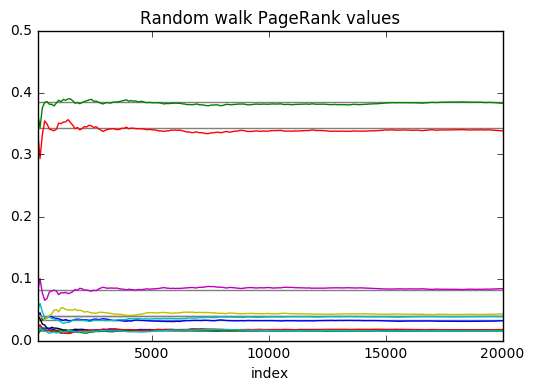

In [5]:
pages = {"B":["C"],
         "C":["B"],
         "D":["A","B"],
         "E":["B","D","F"],
         "F":["B","E"],
         "G":["B","E"],
         "H":["B","E"],
         "I":["B","E"],
         "J":["E"],
         "K":["E"]}

teleport = .15
iterations = 20001
all_nodes = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K"]

iterations_to_plot = 200
page_visits = defaultdict(int)
default_val = 1.0/len(all_nodes)
current_page = pages.keys()[0]
mod = iterations//iterations_to_plot
all_page_visits = []

for i in xrange(iterations):
    if rand() < teleport:
        possible_pages = all_nodes
    else:
        possible_pages = pages.get(current_page, all_nodes)
    current_page = choice(possible_pages)
    page_visits[current_page] += 1
    if i%mod == 0:
        dict_to_save = dict(page_visits)
        dict_to_save["index"] = i
        all_page_visits.append(dict_to_save)
    
print(dict(page_visits))
    
total = 0.0
for page, counts in page_visits.items():
    total += counts
    
for page, counts in page_visits.items():
    print("PageRank for page %s: %f" % (page, counts/total))
    
data = pd.DataFrame(all_page_visits[1:])
data.index = data.pop("index")
normalized_data = data.div(data.sum(axis=1), axis=0)
normalized_data.plot(legend=False)
plt.ylim(0,.5)
plt.hlines(true_values,0,iterations-1, colors="grey")
plt.title("Random walk PageRank values");

#### Use power iterations to solve

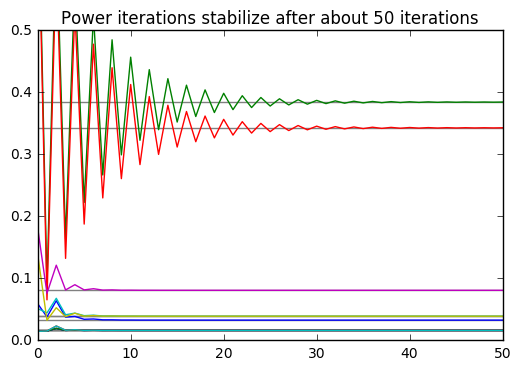

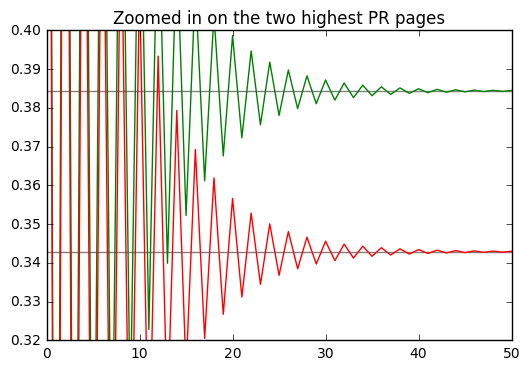

In [6]:
iterations = 51
d = .85

thd = 1/3.0
fll = 1/11.0
T = np.array( [[ fll,  fll,  fll,  fll,  fll,  fll,  fll,  fll,  fll,  fll,  fll],
               [ 0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
               [ 0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
               [ 0.5,  0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
               [ 0. ,  thd,  0. ,  thd,  0. ,  thd,  0. ,  0. ,  0. ,  0. ,  0. ],
               [ 0. ,  0.5,  0. ,  0. ,  0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
               [ 0. ,  0.5,  0. ,  0. ,  0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
               [ 0. ,  0.5,  0. ,  0. ,  0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
               [ 0. ,  0.5,  0. ,  0. ,  0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
               [ 0. ,  0. ,  0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
               [ 0. ,  0. ,  0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ]])

teleport = np.ones(T.shape)/T.shape[0]
T = d*T + (1-d)*teleport

stable = T

all_stables = []

for i in xrange(iterations):
    stable = stable.dot(T)
    all_stables.append(stable.diagonal())

plt.plot(all_stables)
plt.hlines(true_values,0,iterations-1, colors="grey")
plt.title("Power iterations stabilize after about 50 iterations")
plt.ylim(0,.5)
plt.show()

plt.plot(all_stables)
plt.hlines(true_values,0,iterations-1, colors="grey")
plt.title("Zoomed in on the two highest PR pages")
plt.ylim(.32, .4);

#### New algo: Power iteration with compounding T 
Instead of multiplying the current result by the transition matrix, we can start with the transition matrix and multiply it by itself. This results in much faster convergence.

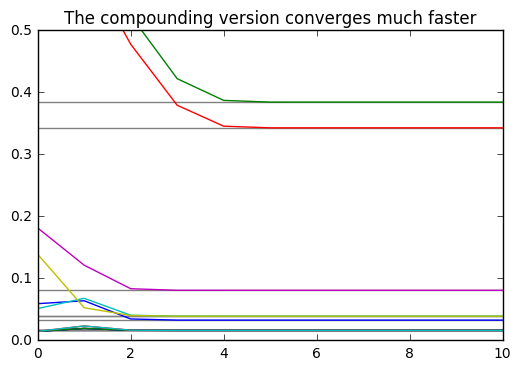

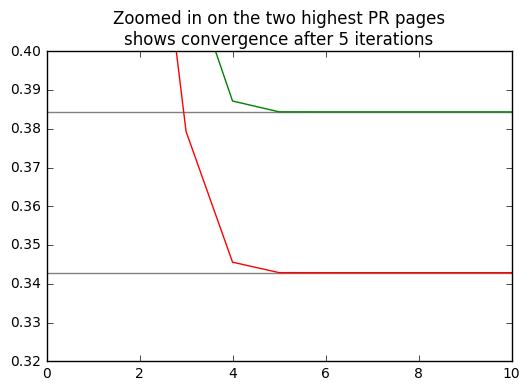

In [89]:
iterations = 11
d = .85

thd = 1/3.0
fll = 1/11.0
T = np.array( [[ fll,  fll,  fll,  fll,  fll,  fll,  fll,  fll,  fll,  fll,  fll],
               [ 0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
               [ 0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
               [ 0.5,  0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
               [ 0. ,  thd,  0. ,  thd,  0. ,  thd,  0. ,  0. ,  0. ,  0. ,  0. ],
               [ 0. ,  0.5,  0. ,  0. ,  0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
               [ 0. ,  0.5,  0. ,  0. ,  0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
               [ 0. ,  0.5,  0. ,  0. ,  0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
               [ 0. ,  0.5,  0. ,  0. ,  0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
               [ 0. ,  0. ,  0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
               [ 0. ,  0. ,  0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ]])

teleport = np.ones(T.shape)/T.shape[0]
T = d*T + (1-d)*teleport

all_stables = []

for i in xrange(iterations):
    T = T.dot(T)
    all_stables.append(T.diagonal())
    
plt.plot(all_stables);
plt.hlines(true_values,0,iterations-1, colors="grey")
plt.title("The compounding version converges much faster")
plt.ylim(0,.5)
plt.show()

plt.plot(all_stables)
plt.hlines(true_values,0,iterations-1, colors="grey")
plt.title("Zoomed in on the two highest PR pages\nshows convergence after 5 iterations")
plt.ylim(.32, .4);

print()

My suspicion is that a four iteration solution is possible, but that is probably the limit given smart default PageRanks are not set for each node.

#### Here is a one-stage solution to the problem that uses a single reducer

In [8]:
%%writefile PageRank.py

from __future__ import print_function, division
from mrjob.job import MRJob
from mrjob.job import MRStep
from mrjob.protocol import JSONProtocol
from sys import stderr

class PageRank(MRJob):
    INPUT_PROTOCOL = JSONProtocol
    
    def configure_options(self):
        super(PageRank, 
              self).configure_options()

        self.add_passthrough_option(
            '--n_nodes', 
            dest='n_nodes', 
            type='float',
            help="""number of nodes 
            that have outlinks. You can
            guess at this because the
            exact number will be 
            updated after the first
            iteration.""")
    
    def mapper(self, key, lines):
        # Handles special keys
        # Calculate new Total PR
        # each iteration
        if key in ["****Total PR"]:
            raise StopIteration
        if key in ["**Distribute", "***n_nodes"]:
            # !!! This is where the special
            # hash to the same reducer code
            # will need to go.
            yield (key, lines)
            raise StopIteration
        # Handles the first time the 
        # mapper is called. The lists
        # are converted to dictionaries 
        # with default PR values.
        if isinstance(lines, list):
            n_nodes = self.options.n_nodes
            default_PR = 1/n_nodes
            lines = {"links":lines, 
                     "PR": default_PR}
            # Also perform a node count
            yield ("***n_nodes", 1.0)
        PR = lines["PR"]
        links = lines["links"]
        n_links = len(links)
        # Pass node onward
        yield (key, lines)
        # Track total PR in system
        yield ("****Total PR", PR)
        # If it is not a dangling node
        # distribute its PR to the 
        # other links.
        if n_links:
            PR_to_send = PR/n_links
            for link in links:
                yield (link, PR_to_send)
        else:
            # !!! This is also where the special
            # hash must go.
            yield ("**Distribute", PR)

    def reducer_init(self):
        self.to_distribute = None
        self.n_nodes = None
        self.total_pr = None
    
    def reducer(self, key, values):
        total = 0
        node_info = None
        
        for val in values:
            if isinstance(val, float):
                total += val
            else:
                node_info = val
                
        if node_info:
            distribute = self.to_distribute or 0
            pr = total + distribute
            decayed_pr = .85 * pr
            teleport_pr = .15/self.n_nodes
            new_pr = decayed_pr + teleport_pr
            node_info["PR"] = new_pr
            yield (key, node_info)
        elif key == "****Total PR":
            self.total_pr = total
            yield (key, total)
        elif key == "***n_nodes":
            self.n_nodes = total
            yield (key, total)
        elif key == "**Distribute":
            extra_mass = total
            # Because the node_count and
            # the mass distribution are 
            # eventually consistent, a
            # simple correction for any early
            # discrepancies is a good fix
            excess_pr = self.total_pr - 1
            weight = extra_mass - excess_pr
            self.to_distribute = weight/self.n_nodes
        else:
            # The only time this should run
            # is when dangling nodes are 
            # discovered during the first
            # iteration. By making them
            # explicitly tracked, the mapper
            # can handle them from now on.
            yield ("**Distribute", total)
            yield ("***n_nodes", 1.0)
            yield (key, {"PR": total, 
                         "links": []})
            
    def steps(self):
        mr_steps = [MRStep(mapper=self.mapper,
                           reducer_init=self.reducer_init,
                           reducer=self.reducer)]*50
        return mr_steps
        
if __name__ == "__main__":
    PageRank.run()

Overwriting PageRank.py


In [9]:
%reload_ext autoreload
%autoreload 2
from PageRank import PageRank

mr_job = PageRank(args=["data/PageRank-test.txt", 
                        "--n_nodes=11", 
                        "--jobconf=mapred.reduce.tasks=1"])
with mr_job.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        print(mr_job.parse_output_line(line))

(u'****Total PR', 1.0)
(u'***n_nodes', 11.0)
(u'A', {u'PR': 0.03278149315934761, u'links': []})
(u'B', {u'PR': 0.3843611835646984, u'links': [u'C']})
(u'C', {u'PR': 0.34295005075721485, u'links': [u'B']})
(u'D', {u'PR': 0.039087092099970085, u'links': [u'A', u'B']})
(u'E', {u'PR': 0.08088569323450426, u'links': [u'B', u'D', u'F']})
(u'F', {u'PR': 0.039087092099970085, u'links': [u'B', u'E']})
(u'G', {u'PR': 0.016169479016858924, u'links': [u'B', u'E']})
(u'H', {u'PR': 0.016169479016858924, u'links': [u'B', u'E']})
(u'I', {u'PR': 0.016169479016858924, u'links': [u'B', u'E']})
(u'J', {u'PR': 0.016169479016858924, u'links': [u'E']})
(u'K', {u'PR': 0.016169479016858924, u'links': [u'E']})


#### Here is a one-stage solution that uses multiple reducers

In [87]:
%%writefile PageRank.py
from __future__ import print_function, division
import itertools
from mrjob.job import MRJob
from mrjob.job import MRStep
from mrjob.protocol import JSONProtocol
from sys import stderr
from random import random

class PageRank(MRJob):
    INPUT_PROTOCOL = JSONProtocol
    
    def configure_options(self):
        super(PageRank, 
              self).configure_options()

        self.add_passthrough_option(
            '--n_nodes', 
            dest='n_nodes', 
            type='float',
            help="""number of nodes 
            that have outlinks. You can
            guess at this because the
            exact number will be 
            updated after the first
            iteration.""")
        
        self.add_passthrough_option(
            '--reduce.tasks', 
            dest='reducers', 
            type='int',
            help="""number of reducers
            to use. Controls the hash
            space of the custom
            partitioner""")
        
        self.add_passthrough_option(
            '--iterations', 
            dest='iterations', 
            type='int',
            help="""number of iterations
            to perform.""")
        
        self.add_passthrough_option(
            '--damping_factor', 
            dest='d', 
            default=.85,
            type='float',
            help="""Is the damping
            factor. Must be between
            0 and 1.""")
        
        self.add_passthrough_option(
            '--smart_updating', 
            dest='smart_updating', 
            type='str',
            default="False",
            help="""Can be True or
            False. If True, all updates
            to the new PR will take into
            account the value of the old
            PR.""")
        
    def mapper_init(self):
        self.values = {"****Total PR": 0.0,
                       "***n_nodes": 0.0,
                       "**Distribute": 0.0}
        self.n_reducers = self.options.reducers
    
    def mapper(self, key, lines):
        n_reducers = self.n_reducers
        key_hash = hash(key)%n_reducers
        # Handles special keys
        # Calculate new Total PR
        # each iteration
        if key in ["****Total PR"]:
            raise StopIteration
        if key in ["**Distribute"]:
            self.values[key] += lines
            raise StopIteration
        if key in ["***n_nodes"]:
            self.values[key] += lines
            raise StopIteration
        # Handles the first time the 
        # mapper is called. The lists
        # are converted to dictionaries 
        # with default PR values.
        if isinstance(lines, list):
            n_nodes = self.options.n_nodes
            default_PR = 1/n_nodes
            lines = {"links":lines, 
                     "PR": default_PR}
        # Perform a node count each time
        self.values["***n_nodes"] += 1.0
        PR = lines["PR"]
        links = lines["links"]
        n_links = len(links)
        # Pass node onward
        yield (key_hash, (key, lines))
        # Track total PR in system
        self.values["****Total PR"] += PR
        # If it is not a dangling node
        # distribute its PR to the 
        # other links.
        if n_links:
            PR_to_send = PR/n_links
            for link in links:
                link_hash = hash(link)%n_reducers
                yield (link_hash, (link, PR_to_send))
        else:
            self.values["**Distribute"] = PR

    def mapper_final(self):
        for key, value in self.values.items():
            for k in range(self.n_reducers):
                yield (k, (key, value))
            
    def reducer_init(self):
        self.d = self.options.d
        smart = self.options.smart_updating
        if smart == "True":
            self.smart = True
        elif smart == "False":
            self.smart = False
        else:
            msg = """--smart_updating should 
                       be True or False"""
            raise Exception(msg)
        self.to_distribute = None
        self.n_nodes = None
        self.total_pr = None

    def reducer(self, hash_key, combo_values):
        gen_values = itertools.groupby(combo_values, 
                                       key=lambda x:x[0])
        for key, values in gen_values:
            total = 0
            node_info = None

            for key, val in values:
                if isinstance(val, float):
                    total += val
                else:
                    node_info = val

            if node_info:
                old_pr = node_info["PR"]
                distribute = self.to_distribute or 0
                pr = total + distribute
                decayed_pr = self.d * pr
                teleport_pr = (1-self.d)/self.n_nodes
                new_pr = decayed_pr + teleport_pr
                if self.smart:
                    # If the new value is less than
                    # 30% different than the old
                    # value, set the new PR to be
                    # 80% of the new value and 20% 
                    # of the old value.
                    diff = abs(new_pr - old_pr)
                    percent_diff = diff/old_pr
                    if percent_diff < .3:
                        new_pr = .8*new_pr + .2*old_pr
                node_info["PR"] = new_pr
                yield (key, node_info)
            elif key == "****Total PR":
                self.total_pr = total
            elif key == "***n_nodes":
                self.n_nodes = total
            elif key == "**Distribute":
                extra_mass = total
                # Because the node_count and
                # the mass distribution are 
                # eventually consistent, a
                # simple correction for any early
                # discrepancies is a good fix
                excess_pr = self.total_pr - 1
                weight = extra_mass - excess_pr
                self.to_distribute = weight/self.n_nodes
            else:
                # The only time this should run
                # is when dangling nodes are 
                # discovered during the first
                # iteration. By making them
                # explicitly tracked, the mapper
                # can handle them from now on.
                yield ("**Distribute", total)
                yield ("***n_nodes", 1.0)
                yield (key, {"PR": total, 
                             "links": []})

    def reducer_final(self):
        print_info = False
        if print_info:
            print("Total PageRank", self.total_pr)
        
    def steps(self):
        iterations = self.options.iterations
        mr_steps = [MRStep(mapper_init=self.mapper_init,
                           mapper=self.mapper,
                           mapper_final=self.mapper_final,
                           reducer_init=self.reducer_init,
                           reducer=self.reducer,
                           reducer_final=self.reducer_final)]
        return mr_steps*iterations


if __name__ == "__main__":
    PageRank.run()

Overwriting PageRank.py


This implementation converges to the correct answer. Fifty iterations takes about 2.5 seconds.

In [79]:
%%time
%reload_ext autoreload
%autoreload 2
from PageRank import PageRank

mr_job = PageRank(args=["data/PageRank-test.txt", 
                        "--iterations=50",
                        "--n_nodes=11",
                        "--damping_factor=.85",
                        "--jobconf=mapred.reduce.tasks=5",
                        "--reduce.tasks=5"])

results = {}
with mr_job.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        result = mr_job.parse_output_line(line)
        results[result[0]] = result[1]["PR"]
pprint(results)

{u'A': 0.03278149315934773,
 u'B': 0.3843730253341818,
 u'C': 0.342938208987731,
 u'D': 0.03908709209997017,
 u'E': 0.08088569323450442,
 u'F': 0.03908709209997017,
 u'G': 0.016169479016858956,
 u'H': 0.016169479016858956,
 u'I': 0.016169479016858956,
 u'J': 0.016169479016858956,
 u'K': 0.016169479016858956}
CPU times: user 1.81 s, sys: 508 ms, total: 2.31 s
Wall time: 2.58 s


The chart below investigates how the PageRank parameters evolve as a function of the number of iterations in the standard algorithm. 

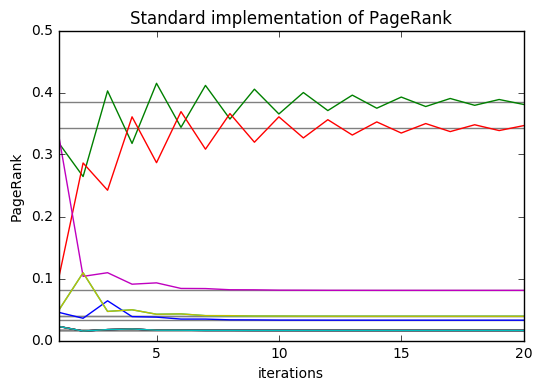

In [86]:
%reload_ext autoreload
%autoreload 2
from PageRank import PageRank

all_results = []

for iteration in range(1, 21):
    mr_job = PageRank(args=["data/PageRank-test.txt", 
                            "--iterations=%d" % iteration, 
                            "--n_nodes=11",
                            "--damping_factor=.85",
                            "--jobconf=mapred.reduce.tasks=5",
                            "--reduce.tasks=5"])

    results = {}
    with mr_job.make_runner() as runner:
        runner.run()
        for line in runner.stream_output():
            result = mr_job.parse_output_line(line)
            try:
                results[result[0]] = result[1]["PR"]
            except:
                pass
        results["index"] = iteration
    all_results.append(results)
    
data = pd.DataFrame(all_results)
data.index = data.pop("index")
data.plot(kind="line", legend=False)
plt.hlines(true_values,0,iterations-1, colors="grey")
plt.title("Standard implementation of PageRank")
plt.xlabel("iterations")
plt.ylabel("PageRank")
plt.ylim(0,.5)
plt.show()

Notice the oscillation in the scores above. This is likely because there is a feedback loop between the two most highly ranked pages. This oscillation makes sense because B and C are only linked to each other and they both have very high PageRank scores.

In order to fix this and increase the speed of convergence, I added a new PageRank update rule that can be turned on using the `--smart_updating=True` argument. This update rule does the following:  
* Compare the old and new PageRank for a node
* If the percent difference is less than 30%, the actual PageRank value assigned to the node is 75% of the new value plus 25% of the old value.

If there is a big change between the old and new PageRank values (common during the first iterations of the algorithm), the actual PageRank value used is the standard value used. This allows each page to rapidly get to its approximately correct place. 

If there is not a big change, oscillations are removed by smoothing the new PageRank value with the past PageRank value.

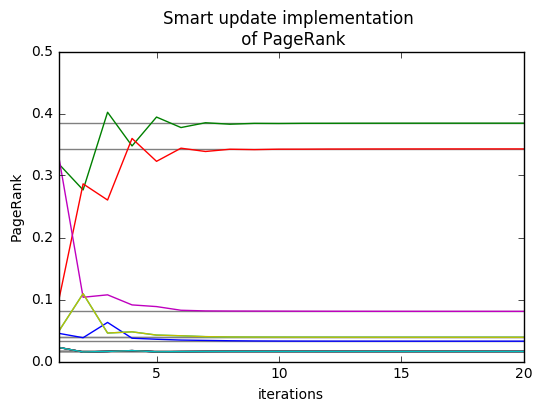

In [88]:
%reload_ext autoreload
%autoreload 2
from PageRank import PageRank

all_results = []

for iteration in range(1, 21):
    mr_job = PageRank(args=["data/PageRank-test.txt", 
                            "--iterations=%d" % iteration, 
                            "--n_nodes=11",
                            "--damping_factor=.85",
                            "--jobconf=mapred.reduce.tasks=5",
                            "--reduce.tasks=5",
                            "--smart_updating=True"])

    results = {}
    with mr_job.make_runner() as runner:
        runner.run()
        for line in runner.stream_output():
            result = mr_job.parse_output_line(line)
            try:
                results[result[0]] = result[1]["PR"]
            except:
                pass
        results["index"] = iteration
    all_results.append(results)
    
data = pd.DataFrame(all_results)
data.index = data.pop("index")
data.plot(kind="line", legend=False)
plt.hlines(true_values,0,iterations-1, colors="grey")
plt.title("Smart update implementation \n of PageRank")
plt.xlabel("iterations")
plt.ylabel("PageRank")
plt.ylim(0,.5)
plt.show()

The updated algorithm converges much faster on the dataset and the oscillations are removed.

<h2 style="color:darkgreen">  HW 9.1 Analysis </h2>
In the lectures, it was said that a one-stage PageRank algorithm was not possible. This is a working, fully distributed, one-stage PageRank algorithm. 

Also, we found that we could adjust the update process to lead to significantly faster convergences on this dataset.
<br><br>

## 3.  HW9.2: Exploring PageRank teleportation and network plots <a name="1.2"></a>
[Back to Table of Contents](#TOC)


* In order to overcome  problems such as disconnected components, the damping factor (a typical value for d is 0.85) can be varied. 
* Using the graph in HW1, plot the test graph (using networkx, https://networkx.github.io/) for several values of the damping parameter alpha, so that each nodes radius is proportional to its PageRank score. 
* In particular you should do this for the following damping factors: [0,0.25,0.5,0.75, 0.85, 1]. 
* Note your plots should look like the following: https://en.wikipedia.org/wiki/PageRank#/media/File:PageRanks-Example.svg

<h2 style="color:darkgreen"> HW 9.2 Implementation </h2>

In [91]:
import networkx as nx

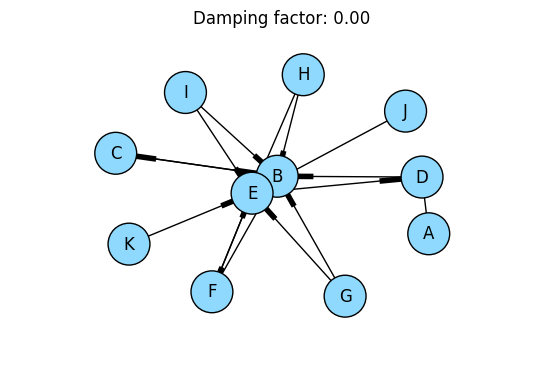

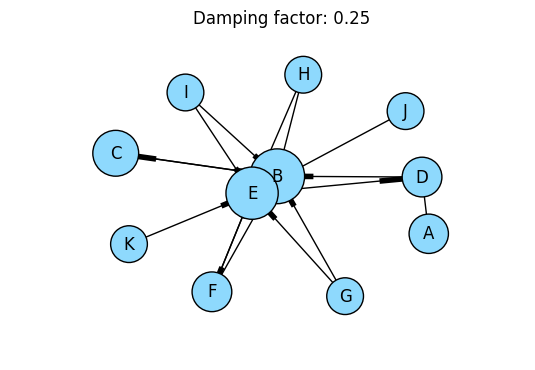

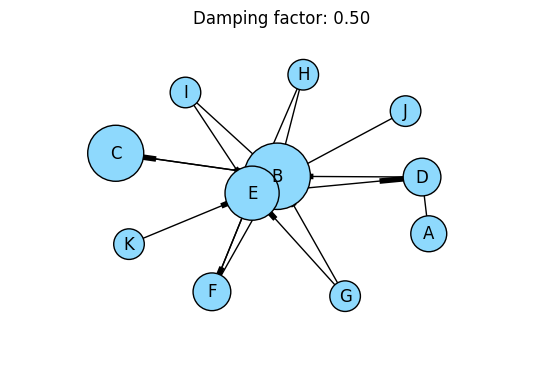

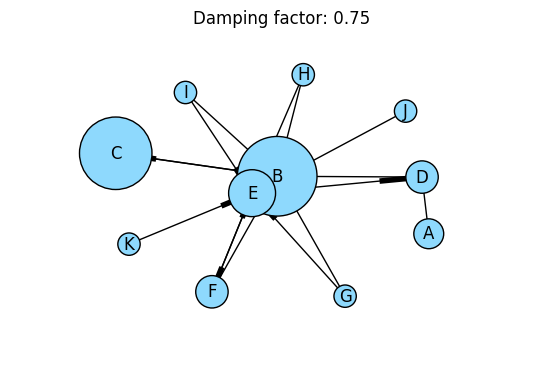

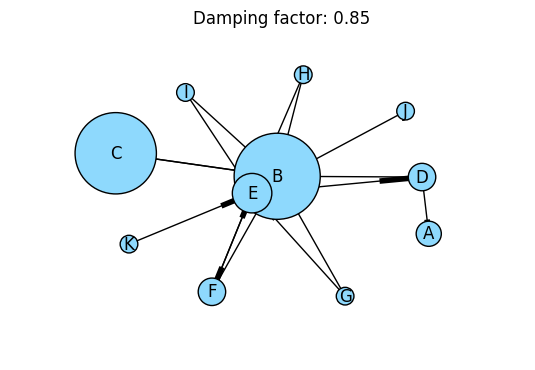

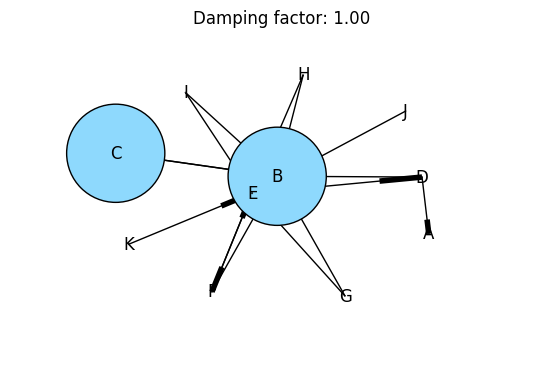

In [164]:
def display_graph(edges, PageRanks, title, node_scaling=10000, pos=None):
    DG = nx.DiGraph()
    DG.add_edges_from(edges)
    
    w = []
    for node in DG.nodes():
        weight = PageRanks[node]
        w.append(weight*node_scaling)
        
    nx.draw_networkx(DG, 
                     node_size=w, 
                     node_color="#8ED9FD",
                     pos=pos)
    plt.title(title)
    plt.axis('off')
    plt.show()
    
    
pages = {"B":["C"],
         "C":["B"],
         "D":["A","B"],
         "E":["B","D","F"],
         "F":["B","E"],
         "G":["B","E"],
         "H":["B","E"],
         "I":["B","E"],
         "J":["E"],
         "K":["E"]}

edges = []

for page, links in pages.items():
    for link in links:
        edges.append([page, link])

# Get constant positions
DG = nx.DiGraph()
DG.add_edges_from(edges)
pos = nx.layout.spring_layout(DG)

for damping_factor in [0,0.25,0.5,0.75, 0.85, 1]:
    mr_job = PageRank(args=["data/PageRank-test.txt", 
                            "--iterations=20", 
                            "--n_nodes=11",
                            "--damping_factor=%f" % damping_factor,
                            "--jobconf=mapred.reduce.tasks=5",
                            "--reduce.tasks=5",
                            "--smart_updating=True"])
    results = {}
    with mr_job.make_runner() as runner:
        runner.run()
        for line in runner.stream_output():
            result = mr_job.parse_output_line(line)
            try:
                results[result[0]] = result[1]["PR"]
            except:
                pass
            
    display_graph(edges, results, "Damping factor: %.2f" % damping_factor, pos=pos)

## 3.  HW9.3: Applying PageRank to the Wikipedia hyperlinks network <a name="1.3"></a>
[Back to Table of Contents](#TOC)

<
* Run your PageRank implementation on the Wikipedia dataset for 5 iterations, and display the top 100 ranked nodes (with alpha = 0.85).
* Run your PageRank implementation on the Wikipedia dataset for 10 iterations, and display the top 100 ranked nodes (with teleportation factor of 0.15).
* Have the top 100 ranked pages changed? Comment on your findings. 
* Plot the pagerank values for the top 100 pages resulting from the 5 iterations run. Then plot the pagerank values for the same 100 pages that resulted from the 10 iterations run.  


<h2 style="color:darkgreen"> HW 9.3 Implementation </h2>

In [ ]:
## Code goes here

In [ ]:
## Drivers & Runners

In [ ]:
## Run Scripts, S3 Sync

 <h2 style="color:darkgreen">  HW 9.3 Analysis </h2>




<br><br>

## 3.  HW9.4: Topic-specific PageRank implementation using MRJob <a name="1.4"></a>
[Back to Table of Contents](#TOC)

Modify your PageRank implementation to produce a topic specific PageRank implementation, as described in:

http://www-cs-students.stanford.edu/~taherh/papers/topic-sensitive-pagerank.pdf

Note in this article that there is a special caveat to ensure that the transition matrix is irreducible.   
This caveat lies in footnote 3 on page 3:
```
	A minor caveat: to ensure that M is irreducible when p
	contains any 0 entries, nodes not reachable from nonzero
	nodes in p should be removed. In practice this is not problematic.
```
and must be adhered to for convergence to be guaranteed.   

Run topic specific PageRank on the following randomly generated network of 100 nodes:

> s3://ucb-mids-mls-networks/randNet.txt (also available on Dropbox)

which are organized into ten topics, as described in the file:

> s3://ucb-mids-mls-networks/randNet_topics.txt  (also available on Dropbox)

Since there are 10 topics, your result should be 11 PageRank vectors (one for the vanilla PageRank implementation in 9.1, and one for each topic with the topic specific implementation). Print out the top ten ranking nodes and their topics for each of the 11 versions, and comment on your result. Assume a teleportation factor of 0.15 in all your analyses.

One final and important comment here:  please consider the requirements for irreducibility with topic-specific PageRank. In particular, the literature ensures irreducibility by requiring that nodes not reachable from in-topic nodes be removed from the network.

This is not a small task, especially as it it must be performed separately for each of the (10) topics.

So, instead of using this method for irreducibility, please comment on why the literature's method is difficult to implement, and what what extra computation it will require.   

Then for your code, please use the alternative, non-uniform damping vector:

```
vji = beta*(1/|Tj|); if node i lies in topic Tj

vji = (1-beta)*(1/(N - |Tj|)); if node i lies outside of topic Tj
```
for beta in (0,1) close to 1. 

With this approach, you will not have to delete any nodes. If beta > 0.5, PageRank is topic-sensitive, and if beta < 0.5, the PageRank is anti-topic-sensitive. For any value of beta irreducibility should hold, so please try beta=0.99, and perhaps some other values locally, on the smaller networks.

<h2 style="color:darkgreen"> HW 9.4 Implementation </h2>

In [ ]:
## Code goes here

In [87]:
%%writefile TopicPageRank.py
from __future__ import print_function, division
import itertools
from mrjob.job import MRJob
from mrjob.job import MRStep
from mrjob.protocol import JSONProtocol
from sys import stderr
from random import random

class TopicPageRank(MRJob):
    INPUT_PROTOCOL = JSONProtocol
    
    def configure_options(self):
        super(PageRank, 
              self).configure_options()

        self.add_passthrough_option(
            '--n_nodes', 
            dest='n_nodes', 
            type='float',
            help="""number of nodes 
            that have outlinks. You can
            guess at this because the
            exact number will be 
            updated after the first
            iteration.""")
        
        self.add_passthrough_option(
            '--reduce.tasks', 
            dest='reducers', 
            type='int',
            help="""number of reducers
            to use. Controls the hash
            space of the custom
            partitioner""")
        
        self.add_passthrough_option(
            '--iterations', 
            dest='iterations', 
            type='int',
            help="""number of iterations
            to perform.""")
        
        self.add_passthrough_option(
            '--damping_factor', 
            dest='d', 
            default=.85,
            type='float',
            help="""Is the damping
            factor. Must be between
            0 and 1.""")
        
        self.add_passthrough_option(
            '--smart_updating', 
            dest='smart_updating', 
            type='str',
            default="False",
            help="""Can be True or
            False. If True, all updates
            to the new PR will take into
            account the value of the old
            PR.""")
        
    def mapper_init(self):
        self.values = {"****Total PR": 0.0,
                       "***n_nodes": 0.0,
                       "**Distribute": 0.0} ### Distribute should be a dictionary where keys
                                            ### are topics and values are PR
        self.n_reducers = self.options.reducers
    
    def mapper(self, key, lines):
        n_reducers = self.n_reducers
        key_hash = hash(key)%n_reducers
        # Handles special keys
        # Calculate new Total PR
        # each iteration
        if key == "****Total PR":
            raise StopIteration
        if key == "**Distribute":
            self.values[key] += lines
            raise StopIteration
        if key == "***n_nodes":
            self.values[key] += lines
            raise StopIteration
        # Handles the first time the 
        # mapper is called. The lists
        # are converted to dictionaries 
        # with default PR values.
        if isinstance(lines, list):
            n_nodes = self.options.n_nodes
            default_PR = 1/n_nodes
            lines = {"links":lines, 
                     "PR": default_PR}
        # Perform a node count each time
        self.values["***n_nodes"] += 1.0
        PR = lines["PR"]
        links = lines["links"]
        n_links = len(links)
        # Pass node onward
        yield (key_hash, (key, lines))
        # Track total PR in system
        self.values["****Total PR"] += PR
        # If it is not a dangling node
        # distribute its PR to the 
        # other links.
        if n_links:
            PR_to_send = PR/n_links
            for link in links:
                link_hash = hash(link)%n_reducers
                yield (link_hash, (link, PR_to_send))
        else:
            self.values["**Distribute"] = PR

    def mapper_final(self):
        for key, value in self.values.items():
            for k in range(self.n_reducers):
                yield (k, (key, value))
            
    def reducer_init(self):
        self.d = self.options.d
        smart = self.options.smart_updating
        if smart == "True":
            self.smart = True
        elif smart == "False":
            self.smart = False
        else:
            msg = """--smart_updating should 
                       be True or False"""
            raise Exception(msg)
        self.to_distribute = None
        self.n_nodes = None
        self.total_pr = None

    def reducer(self, hash_key, combo_values):
        gen_values = itertools.groupby(combo_values, 
                                       key=lambda x:x[0])
        for key, values in gen_values:
            total = 0
            node_info = None

            for key, val in values:
                if isinstance(val, float):
                    total += val
                else:
                    node_info = val

            if node_info:
                old_pr = node_info["PR"]
                distribute = self.to_distribute or 0
                pr = total + distribute
                decayed_pr = self.d * pr
                teleport_pr = (1-self.d)/self.n_nodes
                new_pr = decayed_pr + teleport_pr
                if self.smart:
                    # If the new value is less than
                    # 30% different than the old
                    # value, set the new PR to be
                    # 80% of the new value and 20% 
                    # of the old value.
                    diff = abs(new_pr - old_pr)
                    percent_diff = diff/old_pr
                    if percent_diff < .3:
                        new_pr = .8*new_pr + .2*old_pr
                node_info["PR"] = new_pr
                yield (key, node_info)
            elif key == "****Total PR":
                self.total_pr = total
            elif key == "***n_nodes":
                self.n_nodes = total
            elif key == "**Distribute":
                extra_mass = total
                # Because the node_count and
                # the mass distribution are 
                # eventually consistent, a
                # simple correction for any early
                # discrepancies is a good fix
                excess_pr = self.total_pr - 1
                weight = extra_mass - excess_pr
                self.to_distribute = weight/self.n_nodes
            else:
                # The only time this should run
                # is when dangling nodes are 
                # discovered during the first
                # iteration. By making them
                # explicitly tracked, the mapper
                # can handle them from now on.
                yield ("**Distribute", total)
                yield ("***n_nodes", 1.0)
                yield (key, {"PR": total, 
                             "links": []})

    def reducer_final(self):
        print_info = False
        if print_info:
            print("Total PageRank", self.total_pr)
        
    def steps(self):
        iterations = self.options.iterations
        mr_steps = [MRStep(mapper_init=self.mapper_init,
                           mapper=self.mapper,
                           mapper_final=self.mapper_final,
                           reducer_init=self.reducer_init,
                           reducer=self.reducer,
                           reducer_final=self.reducer_final)]
        return mr_steps*iterations


if __name__ == "__main__":
    PageRank.run()

Overwriting PageRank.py


In [87]:
%%writefile PageRank.py
from __future__ import print_function, division
import itertools
from mrjob.job import MRJob
from mrjob.job import MRStep
from mrjob.protocol import JSONProtocol
from sys import stderr
from random import random

class PageRank(MRJob):
    INPUT_PROTOCOL = JSONProtocol
    
    def configure_options(self):
        super(PageRank, 
              self).configure_options()

        self.add_passthrough_option(
            '--n_nodes', 
            dest='n_nodes', 
            type='float',
            help="""number of nodes 
            that have outlinks. You can
            guess at this because the
            exact number will be 
            updated after the first
            iteration.""")
        
        self.add_passthrough_option(
            '--reduce.tasks', 
            dest='reducers', 
            type='int',
            help="""number of reducers
            to use. Controls the hash
            space of the custom
            partitioner""")
        
        self.add_passthrough_option(
            '--iterations', 
            dest='iterations', 
            type='int',
            help="""number of iterations
            to perform.""")
        
        self.add_passthrough_option(
            '--damping_factor', 
            dest='d', 
            default=.85,
            type='float',
            help="""Is the damping
            factor. Must be between
            0 and 1.""")
        
        self.add_passthrough_option(
            '--smart_updating', 
            dest='smart_updating', 
            type='str',
            default="False",
            help="""Can be True or
            False. If True, all updates
            to the new PR will take into
            account the value of the old
            PR.""")
        
    def mapper_init(self):
        self.values = {"****Total PR": 0.0,
                       "***n_nodes": 0.0,
                       "**Distribute": 0.0}
        self.n_reducers = self.options.reducers
    
    def mapper(self, key, lines):
        n_reducers = self.n_reducers
        key_hash = hash(key)%n_reducers
        # Handles special keys
        # Calculate new Total PR
        # each iteration
        if key in ["****Total PR"]:
            raise StopIteration
        if key in ["**Distribute"]:
            self.values[key] += lines
            raise StopIteration
        if key in ["***n_nodes"]:
            self.values[key] += lines
            raise StopIteration
        # Handles the first time the 
        # mapper is called. The lists
        # are converted to dictionaries 
        # with default PR values.
        if isinstance(lines, list):
            n_nodes = self.options.n_nodes
            default_PR = 1/n_nodes
            lines = {"links":lines, 
                     "PR": default_PR}
        # Perform a node count each time
        self.values["***n_nodes"] += 1.0
        PR = lines["PR"]
        links = lines["links"]
        n_links = len(links)
        # Pass node onward
        yield (key_hash, (key, lines))
        # Track total PR in system
        self.values["****Total PR"] += PR
        # If it is not a dangling node
        # distribute its PR to the 
        # other links.
        if n_links:
            PR_to_send = PR/n_links
            for link in links:
                link_hash = hash(link)%n_reducers
                yield (link_hash, (link, PR_to_send))
        else:
            self.values["**Distribute"] = PR

    def mapper_final(self):
        for key, value in self.values.items():
            for k in range(self.n_reducers):
                yield (k, (key, value))
            
    def reducer_init(self):
        self.d = self.options.d
        smart = self.options.smart_updating
        if smart == "True":
            self.smart = True
        elif smart == "False":
            self.smart = False
        else:
            msg = """--smart_updating should 
                       be True or False"""
            raise Exception(msg)
        self.to_distribute = None
        self.n_nodes = None
        self.total_pr = None

    def reducer(self, hash_key, combo_values):
        gen_values = itertools.groupby(combo_values, 
                                       key=lambda x:x[0])
        for key, values in gen_values:
            total = 0
            node_info = None

            for key, val in values:
                if isinstance(val, float):
                    total += val
                else:
                    node_info = val

            if node_info:
                old_pr = node_info["PR"]
                distribute = self.to_distribute or 0
                pr = total + distribute
                decayed_pr = self.d * pr
                teleport_pr = (1-self.d)/self.n_nodes
                new_pr = decayed_pr + teleport_pr
                if self.smart:
                    # If the new value is less than
                    # 30% different than the old
                    # value, set the new PR to be
                    # 80% of the new value and 20% 
                    # of the old value.
                    diff = abs(new_pr - old_pr)
                    percent_diff = diff/old_pr
                    if percent_diff < .3:
                        new_pr = .8*new_pr + .2*old_pr
                node_info["PR"] = new_pr
                yield (key, node_info)
            elif key == "****Total PR":
                self.total_pr = total
            elif key == "***n_nodes":
                self.n_nodes = total
            elif key == "**Distribute":
                extra_mass = total
                # Because the node_count and
                # the mass distribution are 
                # eventually consistent, a
                # simple correction for any early
                # discrepancies is a good fix
                excess_pr = self.total_pr - 1
                weight = extra_mass - excess_pr
                self.to_distribute = weight/self.n_nodes
            else:
                # The only time this should run
                # is when dangling nodes are 
                # discovered during the first
                # iteration. By making them
                # explicitly tracked, the mapper
                # can handle them from now on.
                yield ("**Distribute", total)
                yield ("***n_nodes", 1.0)
                yield (key, {"PR": total, 
                             "links": []})

    def reducer_final(self):
        print_info = False
        if print_info:
            print("Total PageRank", self.total_pr)
        
    def steps(self):
        iterations = self.options.iterations
        mr_steps = [MRStep(mapper_init=self.mapper_init,
                           mapper=self.mapper,
                           mapper_final=self.mapper_final,
                           reducer_init=self.reducer_init,
                           reducer=self.reducer,
                           reducer_final=self.reducer_final)]
        return mr_steps*iterations


if __name__ == "__main__":
    PageRank.run()

Overwriting PageRank.py


In [ ]:
## Drivers & Runners

In [ ]:
## Run Scripts, S3 Sync

<h2 style="color:darkgreen">  HW 9.4 Analysis </h2>




<br><br>

<center><div class='jumbotron'><h3 style='color:darkblue'>---------  OPTIONAL QUESTIONS SECTION --------</h3></div></center>

## 3.  HW9.5: (OPTIONAL) Applying topic-specific PageRank to Wikipedia <a name="1.5"></a>
[Back to Table of Contents](#TOC)


Here you will apply your topic-specific PageRank implementation to Wikipedia, defining topics (very arbitrarily) for each page by the length (number of characters) of the name of the article mod 10, so that there are 10 topics. 

* Once again, print out the top ten ranking nodes and their topics for each of the 11 versions, and comment on your result. Assume a teleportation factor of 0.15 in all your analyses. Run for 10 iterations.
* Plot the pagerank values for the top 100 pages resulting from the 5 iterations run in HW 9.3. 
* Then plot the pagerank values for the same 100 pages that result from the topic specific pagerank after 10 iterations run. 
* Comment on your findings. 

<h2 style="color:darkgreen"> HW 9.5 Implementation </h2>

In [ ]:
## Code goes here

In [ ]:
## Drivers & Runners

In [ ]:
## Run Scripts, S3 Sync

<h2 style="color:darkgreen">  HW 9.5 Analysis </h2>




<br><br>

## 3.  HW9.6:  (OPTIONAL) TextRank <a name="1.6"></a>
[Back to Table of Contents](#TOC)


* What is TextRank? Describe the main steps in the algorithm. Why does TextRank work?
* Implement TextRank in MrJob for keyword phrases (not just unigrams) extraction using co-occurrence based similarity measure with with sizes of N = 2 and 3. And evaluate your code using the following example using precision, recall, and FBeta (Beta=1):
```
"Compatibility of systems of linear constraints over the set of natural numbers
Criteria of compatibility of a system of linear Diophantine equations, strict 
inequations, and nonstrict inequations are considered. Upper bounds for
components of a minimal set of solutions and algorithms of construction of 
minimal generating sets of solutions for all types of systems are given. 
These criteria and the corresponding algorithms for constructing a minimal 
supporting set of solutions can be used in solving all the considered types of 
systems and systems of mixed types." 
```
* The extracted keywords should in the following set:
```
linear constraints, linear diophantine equations, natural numbers, non-strict inequations, strict inequations, upper bounds
```

<h2 style="color:darkgreen"> HW 9.6 Implementation </h2>

In [ ]:
## Code goes here

In [ ]:
## Drivers & Runners

In [ ]:
## Run Scripts, S3 Sync

<h2 style="color:darkgreen">  HW 9.6 Analysis </h2>




<br><br>

<center><div class='jumbotron'><h2 style='color:green'>-------  END OF HWK 9 --------</h2></div></center>